In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection, preprocessing, metrics, ensemble, tree
from sklearn.model_selection import GridSearchCV

In [2]:
# 1. Load Data
file_path = "Case 2 - Customer Churnn.csv"
data = pd.read_csv(filepath_or_buffer=file_path, sep=';')
print(data.head())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [3]:
# 2. Data Info & Clean
print(data.info())
if 'TotalCharges' in data.columns:
    data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
    data['TotalCharges'].fillna(value=data['TotalCharges'].median(), inplace=True)

print("\nMissing values:")
print(data.isna().sum())

print("\nDescriptive statistics:")
print(data.describe())

print("\nJumlah duplikasi:", data.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


<ipython-input-3-ab4a42bf432c>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['TotalCharges'].fillna(value=data['TotalCharges'].median(), inplace=True)


In [4]:
# 3. Label Encoding
encoded_data = data.copy()
encoders = {}
for col in encoded_data.select_dtypes(include=['object']):
    encoder = preprocessing.LabelEncoder()
    encoded_data[col] = encoder.fit_transform(encoded_data[col])
    encoders[col] = encoder

X = encoded_data.drop(columns='Churn')
y = encoded_data['Churn']

X_tr, X_te, y_tr, y_te = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
# 4. Train AdaBoost
base_tree = tree.DecisionTreeClassifier(max_depth=1)
boost_model = ensemble.AdaBoostClassifier(estimator=base_tree, n_estimators=100, learning_rate=1.0, random_state=42)
boost_model.fit(X_tr, y_tr)
y_pred = boost_model.predict(X_te)

print("Accuracy:", metrics.accuracy_score(y_te, y_pred))
print("\nClassification Report:")
print(metrics.classification_report(y_te, y_pred))

Accuracy: 0.8062455642299503

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1036
           1       0.66      0.56      0.60       373

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409



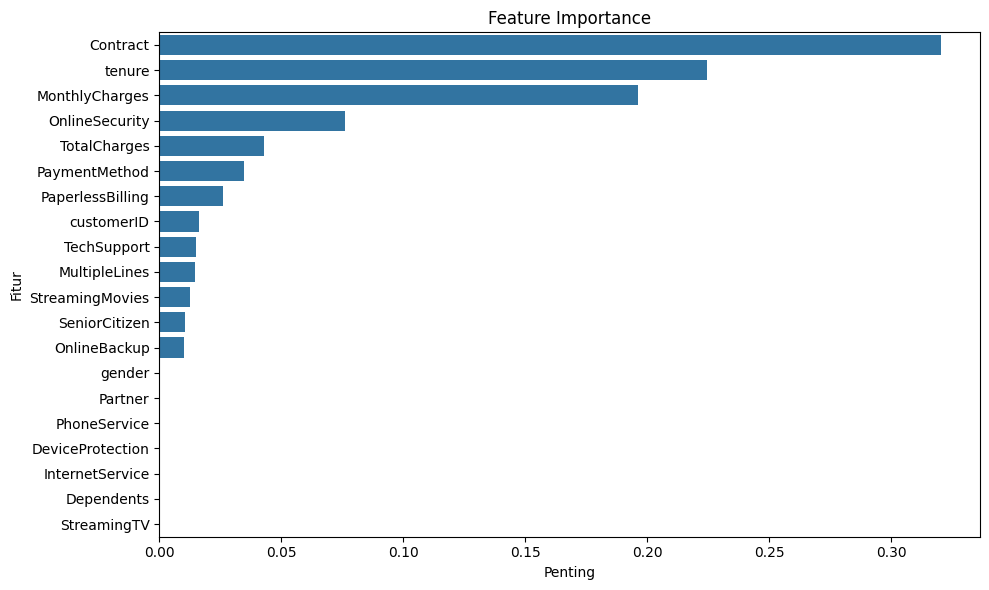

In [6]:
# 5. Feature Importance
try:
    importances = boost_model.feature_importances_
    importance_df = pd.DataFrame({'Fitur': X.columns, 'Penting': importances}).sort_values(by='Penting', ascending=False)

    plt.figure(figsize=(10,6))
    sns.barplot(data=importance_df, x='Penting', y='Fitur')
    plt.title("Feature Importance")
    plt.tight_layout()
    plt.show()
except:
    print("Model tidak mendukung feature_importances_.")


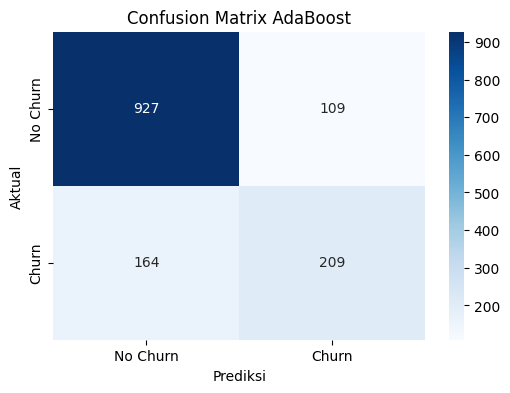

In [7]:
# 6. Confusion Matrix
cmatrix = metrics.confusion_matrix(y_te, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cmatrix, annot=True, cmap='Blues', fmt='d',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title("Confusion Matrix AdaBoost")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

In [8]:
# 7. GridSearchCV Tuning
grid_model = ensemble.AdaBoostClassifier(estimator=tree.DecisionTreeClassifier(), random_state=42)
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.5, 1.0, 1.5],
    'estimator__max_depth': [1, 2, 3]
}

gs = GridSearchCV(estimator=grid_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
gs.fit(X_tr, y_tr)

print("\nBest parameters found:", gs.best_params_)
print("Best cross-validation accuracy:", gs.best_score_)

best_boost = gs.best_estimator_
y_best_pred = best_boost.predict(X_te)
print("\nAccuracy on test set:", metrics.accuracy_score(y_te, y_best_pred))
print("\nClassification Report:")
print(metrics.classification_report(y_te, y_best_pred))


Fitting 5 folds for each of 27 candidates, totalling 135 fits

Best parameters found: {'estimator__max_depth': 3, 'learning_rate': 0.5, 'n_estimators': 100}
Best cross-validation accuracy: 0.8010280519652451

Accuracy on test set: 0.8133427963094393

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1036
           1       0.69      0.54      0.61       373

    accuracy                           0.81      1409
   macro avg       0.77      0.73      0.74      1409
weighted avg       0.80      0.81      0.81      1409



In [9]:
# 8. Prediksi Sample
sample = X_te.iloc[[0]]
result = best_boost.predict(sample)[0]
probability = best_boost.predict_proba(sample)[0][1]

print("\nPrediksi sample:", "Churn" if result == 1 else "Tidak Churn")
print(f"Probabilitas Churn: {probability:.2%}")



Prediksi sample: Churn
Probabilitas Churn: 60.38%


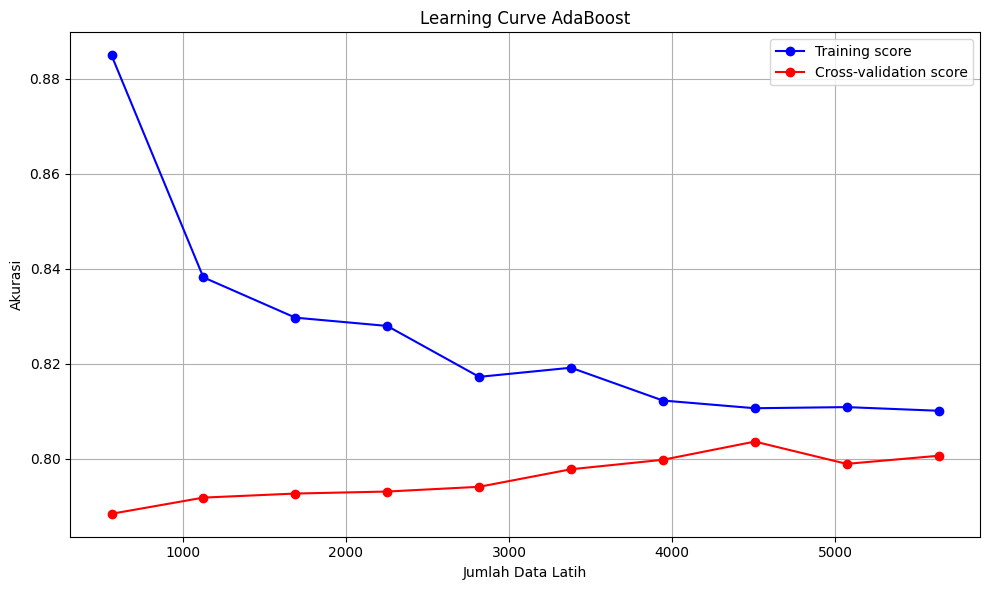

In [11]:
# 9. Learning Curve
from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    best_boost, X, y, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='red', label='Cross-validation score')
plt.title('Learning Curve AdaBoost')
plt.xlabel('Jumlah Data Latih')
plt.ylabel('Akurasi')
plt.legend(loc='best')
plt.grid()
plt.tight_layout()
plt.show()
